# Predcition of Hospital Admission Related to Sore Throat

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sore throat. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'throat_date_'+str(i), 'throat_ab_date_'+str(i), 'throat_ab_type_'+str(i),
                   'incdt_throat_date_'+str(i), 'admitted_throat_date_'+str(i), 'sgss_gp_cov_throat_date_'+str(i)]]
    
    #drop rows with no throat reord
    datum = datum[datum['throat_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with throat_i
    datum = datum[datum['sgss_gp_cov_throat_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'throat_date_'+str(i): 'throat_date', 'throat_ab_date_'+str(i): 'throat_ab_date', 
                           'throat_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_throat_date_'+str(i): 'incdt_throat_date', 'incdt_throat_type_'+str(i): 'incdt_throat_type',
                           'admitted_throat_date_'+str(i): 'admitted_throat_date',
                           'sgss_gp_cov_throat_date_'+str(i): 'sgss_gp_cov_throat_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs): #data_throat_incdt, data_throat_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_throat_admitted',
            event_col='event_throat_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_throat_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_throat_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #save and print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [9]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [10]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [11]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [12]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [13]:
#process 20 throats and concatenate them 
data_throat_1 = proc_infec_data(data,1)
data_throat_2 = proc_infec_data(data,2)
data_throat_3 = proc_infec_data(data,3)
data_throat_4 = proc_infec_data(data,4)
data_throat_5 = proc_infec_data(data,5)
data_throat_6 = proc_infec_data(data,6)
data_throat_7 = proc_infec_data(data,7)
data_throat_8 = proc_infec_data(data,8)
data_throat_9 = proc_infec_data(data,9)
data_throat_10 = proc_infec_data(data,10)
data_throat_11 = proc_infec_data(data,11)
data_throat_12 = proc_infec_data(data,12)
data_throat_13 = proc_infec_data(data,13)
data_throat_14 = proc_infec_data(data,14)
data_throat_15 = proc_infec_data(data,15)
data_throat_16 = proc_infec_data(data,16)
data_throat_17 = proc_infec_data(data,17)
data_throat_18 = proc_infec_data(data,18)
data_throat_19 = proc_infec_data(data,19)
data_throat_20 = proc_infec_data(data,20)

data_throat = pd.concat([data_throat_1, data_throat_2, data_throat_3, data_throat_4, data_throat_5, data_throat_6, data_throat_7, data_throat_8, data_throat_9, data_throat_10, data_throat_11, data_throat_12, data_throat_13, data_throat_14, data_throat_15, data_throat_16, data_throat_17, data_throat_18, data_throat_19, data_throat_20])
data_throat.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [14]:
##add variable season
#convert data types
data_throat['throat_date'] = data_throat['throat_date'].astype('datetime64[ns]')
data_throat['admitted_throat_date'] = data_throat['admitted_throat_date'].astype('datetime64[ns]')
data_throat.died_date = data_throat.died_date.astype('datetime64[ns]')
data_throat.deregistered_date = data_throat.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_throat['date'] = data_throat['throat_date'] 
data_throat['date'] = data_throat['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_throat with today's date in year and month
data_throat = data_throat[data_throat['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_throat = data_throat[data_throat['date'] != last_1_month_date_y_m]
data_throat = data_throat[data_throat['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of throat records
data_throat['season'] = np.nan
data_throat['date_month'] = pd.DatetimeIndex(data_throat['date']).month

conditions = [
    (data_throat['date_month'] >= 3) & (data_throat['date_month'] <= 5),
    (data_throat['date_month'] >= 6) & (data_throat['date_month'] <= 8),
    (data_throat['date_month'] >= 9) & (data_throat['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_throat['season'] = np.select(conditions, choices, default='winter')

In [15]:
#add variable time period
data_throat.loc[(data_throat['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_throat.loc[((data_throat['date'] >= '2020-05') & (data_throat['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_throat.loc[(data_throat['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

In [16]:
data_throat['date'].max()

'2023-03'

#### event and duration

In [17]:
#scenario 1
#not hosped (nothing happened)
data_throat.loc[data_throat['admitted_throat_date'].isnull(), 'event_throat_admitted'] = 0

In [18]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_throat['delta_throat_admitted'] = (data_throat['admitted_throat_date'] - data_throat['throat_date']).dt.days
data_throat.loc[((data_throat['delta_throat_admitted'] >= 0) & (data_throat['delta_throat_admitted'] <= 30)), 'event_throat_admitted'] = 1

#scenario 2
#drop whoever was admitted before throat consultation, i.e. negative value for delta_throat_admitted
data_throat = data_throat[~(data_throat['delta_throat_admitted'] < 0)]

In [19]:
#scenario 3
#censor died patients
data_throat['delta_admitted_died'] = (data_throat['died_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_throat.loc[((data_throat['delta_admitted_died'] >= 0) & (data_throat['delta_admitted_died'] <= 30)), 'event_throat_admitted'] = 0

#scenario 3
#censor deregistered patients
data_throat['delta_admitted_deregistered'] = (data_throat['deregistered_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_throat.loc[((data_throat['delta_admitted_deregistered'] > 0) & (data_throat['delta_admitted_deregistered'] <= 30)), 'event_throat_admitted'] = 0

#agg scenario 3s
data_throat['delta_admitted_died_deregistered'] = data_throat['delta_admitted_deregistered'].combine_first(data_throat['delta_admitted_died'])
data_throat.loc[data_throat['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [20]:
#scenario 1
#any other patients (nothing happened)
data_throat['event_throat_admitted'] = data_throat['event_throat_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_throat['duration_throat_admitted'] = data_throat['delta_throat_admitted'].combine_first(data_throat['delta_admitted_died_deregistered'])
data_throat['duration_throat_admitted'] = data_throat['duration_throat_admitted'].replace(np.NaN, 30)
data_throat.loc[(data_throat['duration_throat_admitted'] > 30), 'duration_throat_admitted'] = 30

#give value 1 to event_throat_admitted if duration_throat_admitted is greater or equal to 0 and less than 30
data_throat.loc[((data_throat['duration_throat_admitted'] >= 0) & (data_throat['duration_throat_admitted'] < 30)), 'event_throat_admitted'] = 1

#drop any rows with value 0 in duration column
data_throat = data_throat[~(data_throat['duration_throat_admitted'] == 0)]

In [21]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_throat.loc[((data_throat['delta_throat_admitted'] > 0) & (data_throat['delta_throat_admitted'] < 30)), 'event_throat_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [22]:
#drop anybody with age less than 18 or 0!
data_throat = data_throat[~(data_throat['age'] < 18)] 
data_throat['age'][data_throat['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_throat = data_throat[data_throat['age_cat'] != '0-4']
data_throat = data_throat[data_throat['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_throat['bmi'][data_throat['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_throat['bmi'] = data_throat['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_throat['antibacterial_brit'][data_throat['antibacterial_brit'] < 0] = np.nan

In [23]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_throat = data_throat.replace({"sex": dict_sex})
data_throat = data_throat.replace({"smoking": dict_smoking})

In [24]:
#drop rows with missing region
if ('region' in data_throat.columns) and (data_throat['region'].isnull().sum() > 0):
   data_throat = data_throat[data_throat['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_throat.columns) and (data_throat['antibacterial_brit'].isnull().sum() > 0):
    data_throat['antibacterial_brit'] = data_throat['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_throat.columns) and (data_throat['ethnicity'].isnull().sum() > 0):
    data_throat['ethnicity'] = data_throat['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_throat.columns) and (data_throat['smoking'].isnull().sum() > 0):
    data_throat['smoking'] = data_throat['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_throat.columns) and (data_throat['imd'].isnull().sum() > 0):
    data_throat['imd'] = data_throat['imd'].fillna(0)

In [25]:
#missing values of bmi assign 5 and 0; categorise bmi
data_throat['bmi_cat'] = 5

for idx, x in enumerate(data_throat['bmi_cat']):
    if data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 30:
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 25) and (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 30):
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 18.5) and (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 25):
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 18.5:
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_throat.columns) and (data_throat['bmi_cat'].isnull().sum() > 0):
    data_throat['bmi_cat'] = data_throat['bmi_cat'].fillna(0)

In [26]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_throat.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_throat['ab_type_cat'] = np.where(data_throat['ab_type'].isin(ab_series[mask].index),'other',data_throat['ab_type'])
#assign no to non ab users
data_throat.loc[data_throat['throat_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_throat['ab_type_cat'] = data_throat['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [27]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_throat = data_throat.replace({"sex": dict_sex})
data_throat = data_throat.replace({"ethnicity": dict_ethnicity})
data_throat = data_throat.replace({"smoking": dict_smoking})
data_throat = data_throat.replace({"imd": dict_imd})
data_throat = data_throat.replace({"bmi_cat": dict_bmi})
data_throat = data_throat.replace({"flu_vaccine": dict_flu})
data_throat = data_throat.replace({"region": dict_region})
data_throat = data_throat.replace({"age_cat": dict_age})
data_throat = data_throat.replace({"ab_type_cat": dict_ab_type})

In [28]:
data_throat.ethnicity.value_counts('NA')

white      0.597836
unknown    0.251335
other      0.076044
asian      0.074784
Name: ethnicity, dtype: float64

In [29]:
data_throat.smoking.value_counts('NA')

unknown         0.413268
smoker          0.391694
never_smoked    0.129328
ex_smoker       0.065710
Name: smoking_status, dtype: float64

In [30]:
data_throat.bmi_cat.value_counts('NA')

obese             0.520241
unknown           0.254326
overweight        0.112860
healthy_weight    0.080064
underweight       0.032509
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [31]:
#categorise CCI
data_throat['CCI_cat'] = pd.cut(data_throat['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_throat['antibacterial_brit'].clip(0, data_throat['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

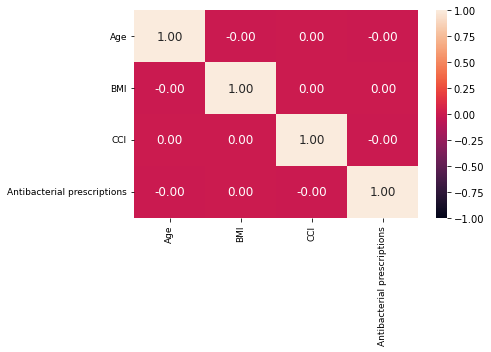

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_throat[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_throat/corr_throat.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [33]:
data_throat = data_throat[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'throat_ab_date', 'ab_type_cat', 'incdt_throat_date', 'date', 'period',
                                   'event_throat_admitted', 'duration_throat_admitted'
                                    ]]

In [34]:
#switch variable throat_ab_date into a binary variable
data_throat[['ab_binary']] = data_throat[['throat_ab_date']].where(data_throat[['throat_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_throat_incdt = data_throat[data_throat['incdt_throat_date'] == 0]
data_throat_prevl = data_throat[data_throat['incdt_throat_date'] == 1]

#no antibiotics and incident hospital admission
data_throat_no_abs_incdt = data_throat_incdt[data_throat_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_throat_abs_incdt = data_throat_incdt[data_throat_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_throat_no_abs_prevl = data_throat_prevl[data_throat_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_throat_abs_prevl = data_throat_prevl[data_throat_prevl['ab_binary'] == 1]

In [35]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_throat_incdt_prepandemic = data_throat_incdt[data_throat_incdt['period'] == 'prepandemic']
data_throat_incdt_during_pandemic = data_throat_incdt[(data_throat_incdt['period'] == 'during_pandemic')]
data_throat_incdt_post_2nd_lockdown = data_throat_incdt[data_throat_incdt['period'] == 'post_2nd_lockdown']
data_throat_prevl_prepandemic = data_throat_prevl[data_throat_prevl['period'] == 'prepandemic']
data_throat_prevl_during_pandemic = data_throat_prevl[(data_throat_prevl['period'] == 'during_pandemic')]
data_throat_prevl_post_2nd_lockdown = data_throat_prevl[data_throat_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_throat_no_abs_incdt_prepandemic = data_throat_incdt_prepandemic[data_throat_incdt_prepandemic['ab_binary'] == 0]
data_throat_no_abs_incdt_during_pandemic = data_throat_incdt_during_pandemic[data_throat_incdt_during_pandemic['ab_binary'] == 0]
data_throat_no_abs_incdt_post_2nd_lockdown = data_throat_incdt_post_2nd_lockdown[data_throat_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_throat_no_abs_prevl_prepandemic = data_throat_prevl_prepandemic[data_throat_prevl_prepandemic['ab_binary'] == 0]
data_throat_no_abs_prevl_during_pandemic = data_throat_prevl_during_pandemic[data_throat_prevl_during_pandemic['ab_binary'] == 0]
data_throat_no_abs_prevl_post_2nd_lockdown = data_throat_prevl_post_2nd_lockdown[data_throat_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [36]:
#store data for plotting hosp admission counts and percentages
%store data_throat
# save data
data_throat.to_csv('../output/hospitalisation_prediction_throat/data_throat.csv')

Stored 'data_throat' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [ ]:
#make summary tables
make_summary_table('throat', 'no_abs_incdt', data_throat_no_abs_incdt)
make_summary_table('throat', 'abs_incdt', data_throat_abs_incdt)
make_summary_table('throat', 'no_abs_prevl', data_throat_no_abs_prevl)
make_summary_table('throat', 'abs_prevl', data_throat_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 108093 total observations, 107399 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 108093
number of events observed = 694
   partial log-likelihood = -8023.19
         time fit was run = 2023-06-28 14:57:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.12            -0.18             0.29                 0.83                 1.34
CCI_cat[T.medium]                0.35       1.42       0.13             0.11             0.60                 1.11                 1.82
CCI_cat[T.high]                  0.23       1.26       0.15            -0.06             0.53                 0.94                 1.70
CCI_cat[T.very_high]             0.17       1.18       0.14            -0.10             0.43                 0.91                 1.54
age_cat[T.25_34]                 0.14       1.15       0.14            -0.13             0.41                 0.88                 1.51
age_cat[T.35_44]                 0.16       1.17       0.14            -0.11             0.42                 0.89                 1.53
age_cat[T.45_54]                -0.04       0.96       0.14            -0.32             0.25                 0.73                 1.28
age_cat[T.55_64]                -0.18       0.84       0.15            -0.47             0.11                 0.62                 1.12
age_cat[T.65_74]                -0.02       0.98       0.14            -0.30             0.26                 0.74                 1.30
age_cat[T.75_more]              -0.01       0.99       0.14            -0.28             0.27                 0.75                 1.31
antibacterial_brit              -0.01       0.99       0.03            -0.07             0.04                 0.93                 1.04
bmi_cat[T.obese]                 0.15       1.16       0.15            -0.15             0.45                 0.86                 1.56
bmi_cat[T.overweight]            0.10       1.11       0.18            -0.26             0.46                 0.77                 1.58
bmi_cat[T.underweight]           0.26       1.30       0.24            -0.22             0.74                 0.81                 2.09
bmi_cat[T.unknown]               0.09       1.09       0.16            -0.23             0.40                 0.79                 1.50
ethnicity[T.other]               0.19       1.21       0.19            -0.19             0.57                 0.82                 1.77
ethnicity[T.unknown]             0.08       1.08       0.16            -0.24             0.40                 0.78                 1.48
ethnicity[T.white]               0.07       1.07       0.15            -0.23             0.37                 0.79                 1.44
flu_vaccine[T.yes]               0.04       1.04       0.12            -0.20             0.28                 0.82                 1.33
imd[T.medium]                    0.11       1.11       0.12            -0.13             0.34                 0.88                 1.40
imd[T.unaffluent]               -0.06       0.94       0.12            -0.30             0.18                 0.74                 1.20
imd[T.unknown]                  -0.14       0.87       0.20            -0.53             0.25                 0.59                 1.29
imd[T.very_affluent]            -0.21       0.81       0.13            -0.46             0.04                 0.63                 1.04
imd[T.very_unaffluent]          -0.05       0.95       0.12            -0.29             0.19                 0.75                 1.21
region[T.east_midlands]         -0.07       0.94       0.17  

13047


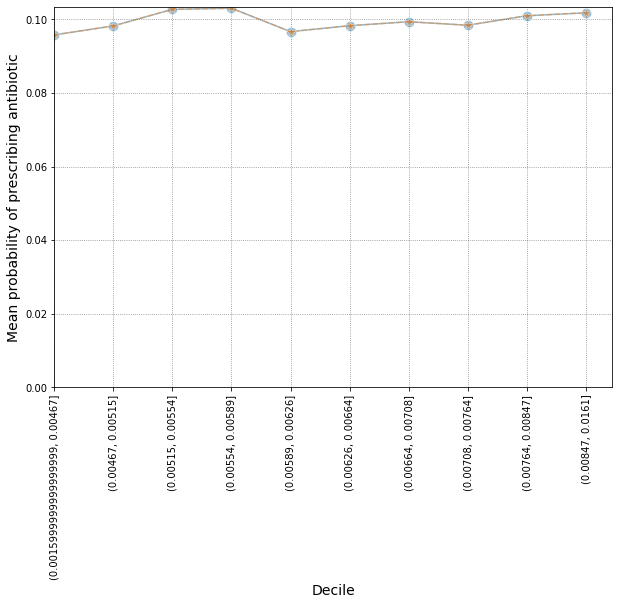


AUROC of LR for deciles with development and validation data: 0.50743 and 0.50445
AUROC of RF for deciles with development and validation data: 0.51787 and 0.50063
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0015999999999999999, 0.00467]  0.108783  0.102083  0.115923
bins_(0.00467, 0.00515]                0.109654  0.102998  0.116741
bins_(0.00515, 0.00554]                0.115389  0.108532  0.122679
bins_(0.00554, 0.00589]                0.116997  0.110074  0.124356
bins_(0.00589, 0.00626]                0.107439  0.100903  0.114399
bins_(0.00626, 0.00664]                0.107340  0.100832  0.114269
bins_(0.00664, 0.00708]                0.110691  0.104046  0.117761
bins_(0.00708, 0.00764]                0.111619  0.104954  0.118707
bins_(0.00764, 0.00847]                0.112155  0.105513  0.119214
bins_(0.00847, 0.0161]                 0.112323  0.105702  0.119359
antibacterial_brit                     0.999341  0.986102  1.012758



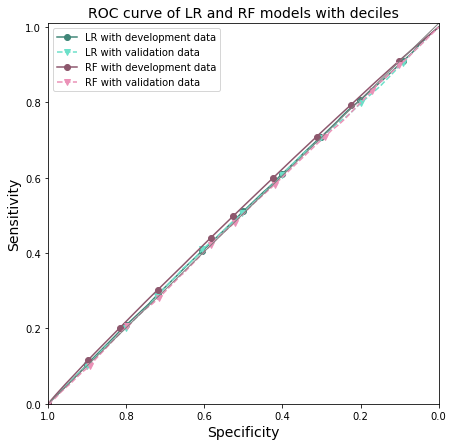

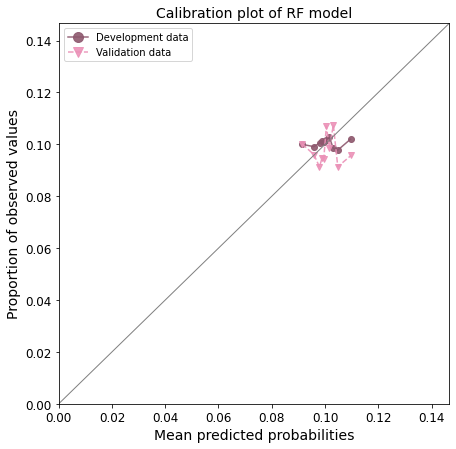

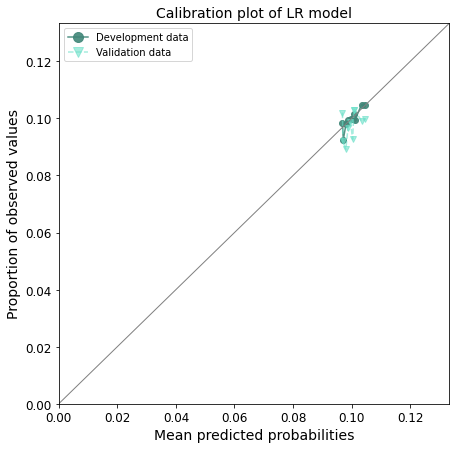


AUROC of LR for risk factors with development and validation data: 0.51744 and 0.49643
AUROC of RF for risk factors with development and validation data: 0.61267 and 0.49856
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.877134       NaN       NaN
age_cat_25_34                0.915999       NaN       NaN
age_cat_35_44                0.918758       NaN       NaN
age_cat_45_54                0.891217       NaN       NaN
age_cat_55_64                0.882809       NaN       NaN
age_cat_65_74                0.846913       NaN       NaN
age_cat_75_more              0.862672       NaN       NaN
sex_female                   0.647635       NaN       NaN
sex_male                     0.655190       NaN       NaN
CCI_cat_high                 0.810122  0.000000       inf
CCI_cat_low                  0.836770  0.000000       inf
CCI_cat_medium               0.874374  0.000000       inf
CCI_cat_very_high            0.827736  0.000000      

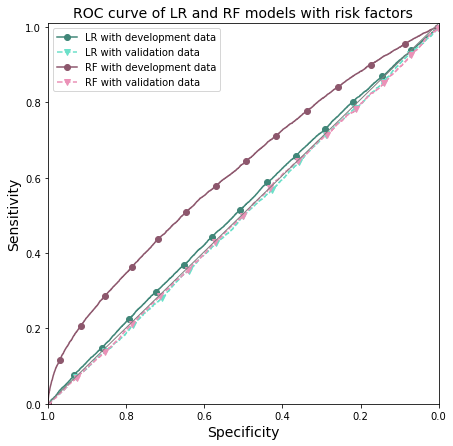

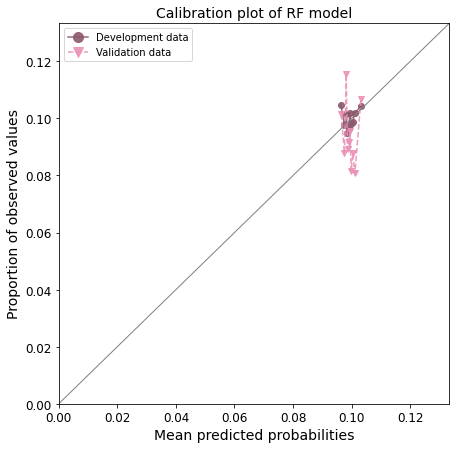

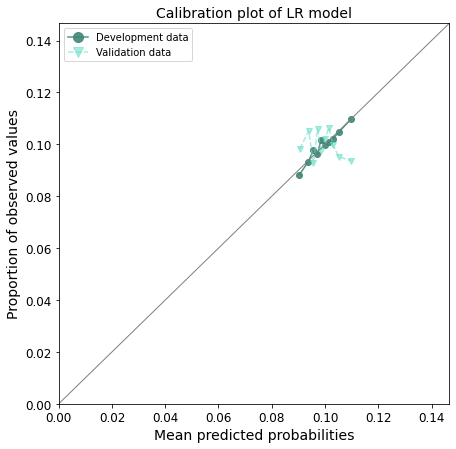

In [37]:
#build cox model for hosp prediction using non ab users' data
prob_pred_throat_no_abs_incdt, prob_pred_throat_no_abs_incdt_bin = cox_build('throat', 'incdt', data_throat_incdt, data_throat_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('throat', 'incdt_deciles', prob_pred_throat_no_abs_incdt)

#make summary table of tables
make_summary_table_deciles('throat', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('throat', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('throat', 'incdt_riskfactors', prob_pred_throat_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('throat', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 11984 total observations, 11923 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 11984
number of events observed = 61
   partial log-likelihood = -541.55
         time fit was run = 2023-06-28 14:59:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.30       1.35       0.47            -0.63             1.22                 0.53                 3.40
CCI_cat[T.medium]                1.06       2.87       0.46             0.15             1.97                 1.16                 7.14
CCI_cat[T.high]                 -0.03       0.97       0.65            -1.30             1.24                 0.27                 3.44
CCI_cat[T.very_high]             0.70       2.02       0.50            -0.28             1.68                 0.75                 5.38
age_cat[T.25_34]                -0.03       0.97       0.52            -1.04             0.99                 0.35                 2.69
age_cat[T.35_44]                 0.10       1.11       0.50            -0.88             1.08                 0.41                 2.95
age_cat[T.45_54]                 1.02       2.79       0.42             0.20             1.85                 1.22                 6.34
age_cat[T.55_64]                 0.17       1.18       0.49            -0.79             1.12                 0.45                 3.07
age_cat[T.65_74]                -0.22       0.80       0.54            -1.28             0.84                 0.28                 2.33
age_cat[T.75_more]              -0.87       0.42       0.68            -2.20             0.46                 0.11                 1.59
antibacterial_brit               0.01       1.01       0.09            -0.17             0.18                 0.85                 1.20
bmi_cat[T.obese]                -0.63       0.53       0.40            -1.42             0.16                 0.24                 1.17
bmi_cat[T.overweight]            0.25       1.28       0.45            -0.62             1.12                 0.54                 3.07
bmi_cat[T.underweight]         -16.32       0.00    2015.22         -3966.09          3933.44                 0.00                  inf
bmi_cat[T.unknown]              -0.70       0.50       0.46            -1.59             0.20                 0.20                 1.22
ethnicity[T.other]              -0.03       0.97       0.71            -1.42             1.36                 0.24                 3.91
ethnicity[T.unknown]             0.38       1.46       0.55            -0.70             1.46                 0.50                 4.29
ethnicity[T.white]               0.02       1.02       0.53            -1.02             1.06                 0.36                 2.90
flu_vaccine[T.yes]               0.22       1.24       0.38            -0.53             0.96                 0.59                 2.62
imd[T.medium]                   -0.82       0.44       0.49            -1.79             0.15                 0.17                 1.16
imd[T.unaffluent]                0.52       1.69       0.35            -0.17             1.22                 0.84                 3.38
imd[T.unknown]                  -0.07       0.93       0.64            -1.33             1.19                 0.27                 3.29
imd[T.very_affluent]            -0.12       0.89       0.40            -0.91             0.67                 0.40                 1.95
imd[T.very_unaffluent]          -0.77       0.46       0.49            -1.74             0.20                 0.18                 1.22
region[T.east_midlands]          0.10       1.11       0.58       

13051


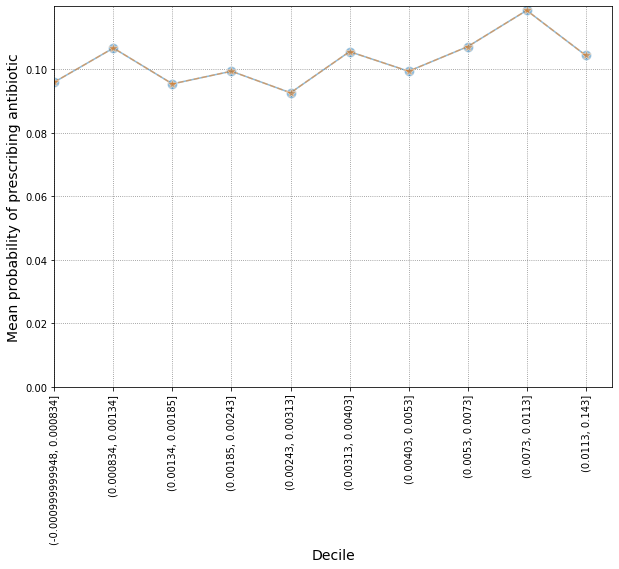


AUROC of LR for deciles with development and validation data: 0.52550 and 0.49589
AUROC of RF for deciles with development and validation data: 0.55192 and 0.50399
LR coefficients:
                                         OR  Lower CI  Upper CI
bins_(-0.000999999948, 0.000834]  0.109013  0.090405  0.131450
bins_(0.000834, 0.00134]          0.124523  0.104256  0.148730
bins_(0.00134, 0.00185]           0.099710  0.082252  0.120873
bins_(0.00185, 0.00243]           0.123892  0.103716  0.147994
bins_(0.00243, 0.00313]           0.101929  0.084230  0.123348
bins_(0.00313, 0.00403]           0.118466  0.099017  0.141736
bins_(0.00403, 0.0053]            0.114649  0.095369  0.137827
bins_(0.0053, 0.0073]             0.114549  0.095226  0.137794
bins_(0.0073, 0.0113]             0.137193  0.115518  0.162934
bins_(0.0113, 0.143]              0.117592  0.098225  0.140779
antibacterial_brit                1.000355  0.962333  1.039880

RF feature importance:
                                    r

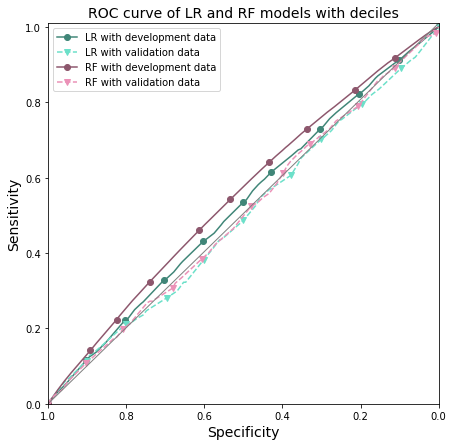

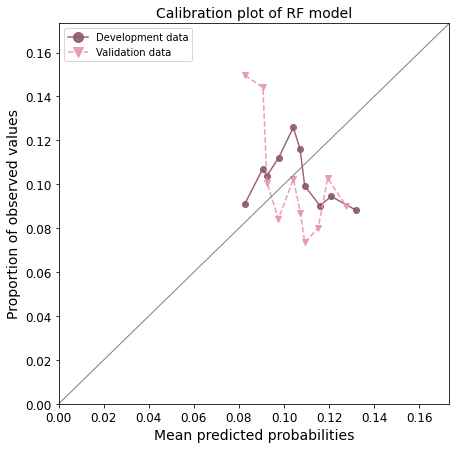

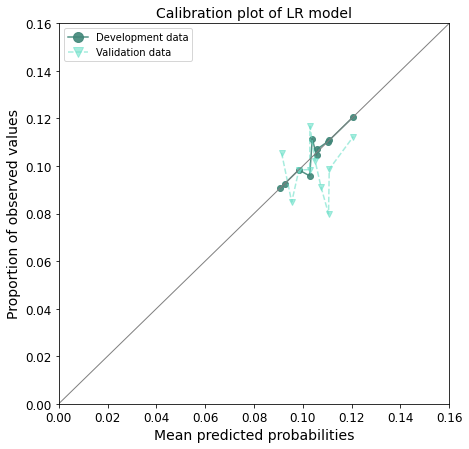


AUROC of LR for risk factors with development and validation data: 0.54330 and 0.53021
AUROC of RF for risk factors with development and validation data: 0.80766 and 0.50977
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.925743       NaN       NaN
age_cat_25_34                0.856762       NaN       NaN
age_cat_35_44                0.824832       NaN       NaN
age_cat_45_54                0.973989       NaN       NaN
age_cat_55_64                0.835943       NaN       NaN
age_cat_65_74                0.871393       NaN       NaN
age_cat_75_more              0.924405       NaN       NaN
sex_female                   0.682185       NaN       NaN
sex_male                     0.628956       NaN       NaN
CCI_cat_high                 0.838754  0.000000       inf
CCI_cat_low                  0.855608  0.000000       inf
CCI_cat_medium               0.799275  0.000000       inf
CCI_cat_very_high            0.872778  0.000000      

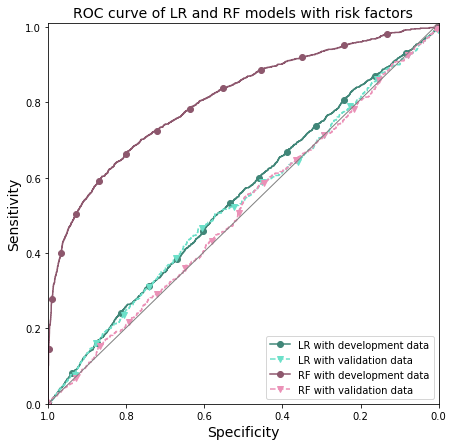

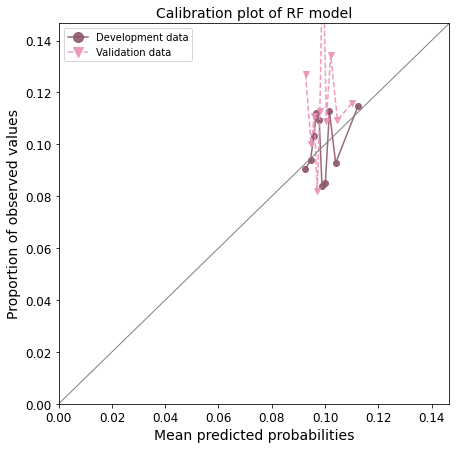

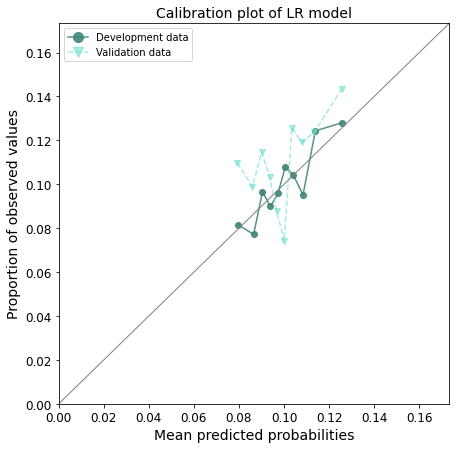

In [38]:
#build cox model for hosp prediction using non ab users' data
prob_pred_throat_no_abs_prevl, prob_pred_throat_no_abs_prevl_bin = cox_build('throat', 'prevl', data_throat_prevl, data_throat_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('throat', 'prevl_deciles', prob_pred_throat_no_abs_prevl)

#make summary table of tables
make_summary_table_deciles('throat', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('throat', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('throat', 'prevl_riskfactors', prob_pred_throat_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('throat', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28765 total observations, 28600 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 28765
number of events observed = 165
   partial log-likelihood = -1669.51
         time fit was run = 2023-06-28 15:00:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.32       1.38       0.26            -0.19             0.83                 0.83                 2.30
CCI_cat[T.medium]                0.57       1.77       0.27             0.04             1.10                 1.04                 3.00
CCI_cat[T.high]                  0.29       1.34       0.34            -0.36             0.95                 0.70                 2.59
CCI_cat[T.very_high]             0.40       1.48       0.29            -0.17             0.97                 0.84                 2.63
age_cat[T.25_34]                 0.13       1.13       0.27            -0.39             0.65                 0.67                 1.91
age_cat[T.35_44]                -0.21       0.81       0.29            -0.77             0.35                 0.46                 1.43
age_cat[T.45_54]                -0.29       0.75       0.30            -0.87             0.29                 0.42                 1.34
age_cat[T.55_64]                -0.67       0.51       0.33            -1.32            -0.03                 0.27                 0.97
age_cat[T.65_74]                -0.09       0.91       0.28            -0.64             0.45                 0.53                 1.57
age_cat[T.75_more]              -0.01       0.99       0.27            -0.54             0.53                 0.58                 1.69
antibacterial_brit              -0.01       0.99       0.06            -0.12             0.10                 0.89                 1.10
bmi_cat[T.obese]                 0.39       1.47       0.33            -0.26             1.04                 0.77                 2.83
bmi_cat[T.overweight]            0.39       1.47       0.39            -0.37             1.15                 0.69                 3.15
bmi_cat[T.underweight]           0.79       2.21       0.46            -0.11             1.69                 0.90                 5.44
bmi_cat[T.unknown]               0.03       1.03       0.36            -0.68             0.74                 0.51                 2.11
ethnicity[T.other]              -0.25       0.78       0.44            -1.11             0.62                 0.33                 1.86
ethnicity[T.unknown]             0.11       1.12       0.33            -0.53             0.75                 0.59                 2.12
ethnicity[T.white]               0.07       1.08       0.31            -0.53             0.67                 0.59                 1.96
flu_vaccine[T.yes]              -0.09       0.91       0.27            -0.62             0.44                 0.54                 1.56
imd[T.medium]                    0.36       1.43       0.25            -0.12             0.84                 0.88                 2.32
imd[T.unaffluent]                0.22       1.24       0.25            -0.28             0.71                 0.76                 2.04
imd[T.unknown]                   0.12       1.13       0.40            -0.67             0.91                 0.51                 2.48
imd[T.very_affluent]            -0.05       0.95       0.27            -0.58             0.49                 0.56                 1.63
imd[T.very_unaffluent]          -0.00       1.00       0.27            -0.53             0.52                 0.59                 1.68
region[T.east_midlands]         -0.14       0.87       0.39     

13060


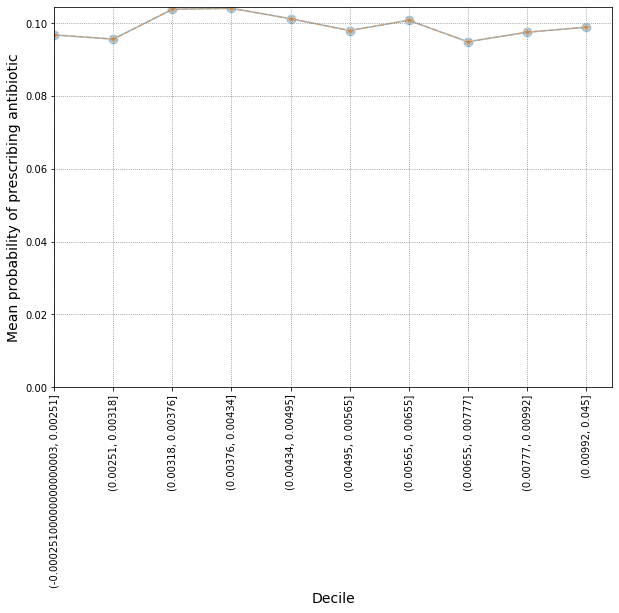


AUROC of LR for deciles with development and validation data: 0.51499 and 0.49053
AUROC of RF for deciles with development and validation data: 0.52891 and 0.48275
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.00025100000000000003, 0.00251]  0.106136  0.093932  0.119925
bins_(0.00251, 0.00318]                  0.097414  0.085895  0.110477
bins_(0.00318, 0.00376]                  0.114650  0.101806  0.129115
bins_(0.00376, 0.00434]                  0.112441  0.099848  0.126623
bins_(0.00434, 0.00495]                  0.112726  0.100093  0.126953
bins_(0.00495, 0.00565]                  0.101203  0.089391  0.114575
bins_(0.00565, 0.00655]                  0.108073  0.095736  0.121999
bins_(0.00655, 0.00777]                  0.103577  0.091605  0.117114
bins_(0.00777, 0.00992]                  0.109841  0.097536  0.123698
bins_(0.00992, 0.045]                    0.111757  0.099156  0.125960
antibacterial_brit                       1.0077

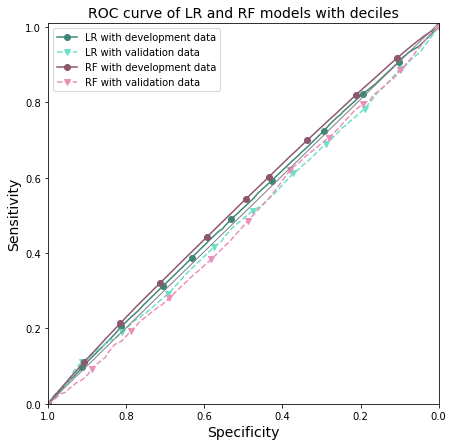

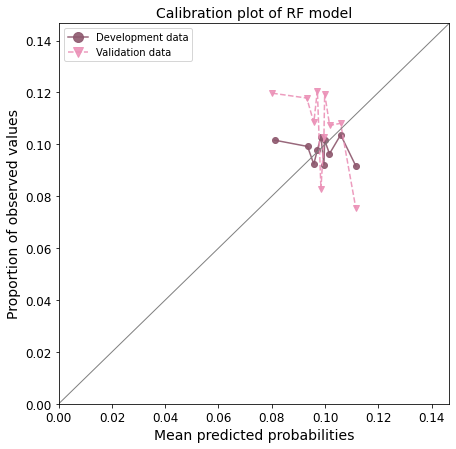

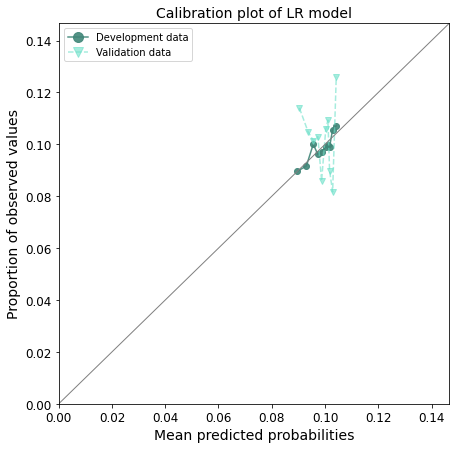

In [39]:
#build cox model for hosp prediction using non ab users' data
prob_pred_throat_no_abs_incdt_prepandemic, prob_pred_throat_no_abs_incdt_prepandemic_bin = cox_build('throat', 'incdt_prepandemic', data_throat_incdt_prepandemic, data_throat_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('throat', 'incdt_prepandemic_deciles', prob_pred_throat_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('throat', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 33077 total observations, 32852 right-censored observations>
             duration col = 'duration_throat_admitted'
                event col = 'event_throat_admitted'
      baseline estimation = breslow
   number of observations = 33077
number of events observed = 225
   partial log-likelihood = -2315.61
         time fit was run = 2023-06-28 15:00:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.34       0.71       0.22            -0.76             0.09                 0.47                 1.09
CCI_cat[T.medium]                0.33       1.39       0.21            -0.08             0.74                 0.92                 2.10
CCI_cat[T.high]                  0.32       1.38       0.25            -0.16             0.81                 0.86                 2.24
CCI_cat[T.very_high]             0.20       1.22       0.23            -0.25             0.64                 0.78                 1.90
age_cat[T.25_34]                 0.08       1.08       0.24            -0.40             0.55                 0.67                 1.74
age_cat[T.35_44]                 0.23       1.25       0.23            -0.23             0.68                 0.79                 1.98
age_cat[T.45_54]                 0.01       1.01       0.25            -0.47             0.50                 0.62                 1.64
age_cat[T.55_64]                -0.19       0.82       0.26            -0.70             0.31                 0.50                 1.36
age_cat[T.65_74]                -0.27       0.76       0.27            -0.79             0.25                 0.45                 1.28
age_cat[T.75_more]              -0.15       0.86       0.25            -0.65             0.35                 0.52                 1.42
antibacterial_brit               0.02       1.02       0.05            -0.08             0.11                 0.93                 1.11
bmi_cat[T.obese]                -0.06       0.94       0.26            -0.57             0.45                 0.56                 1.57
bmi_cat[T.overweight]            0.29       1.33       0.30            -0.30             0.87                 0.74                 2.39
bmi_cat[T.underweight]          -0.38       0.68       0.51            -1.38             0.62                 0.25                 1.86
bmi_cat[T.unknown]               0.02       1.02       0.28            -0.52             0.56                 0.60                 1.76
ethnicity[T.other]               0.17       1.19       0.30            -0.41             0.76                 0.67                 2.13
ethnicity[T.unknown]            -0.47       0.63       0.27            -0.99             0.05                 0.37                 1.05
ethnicity[T.white]              -0.20       0.82       0.23            -0.66             0.26                 0.52                 1.30
flu_vaccine[T.yes]               0.24       1.27       0.20            -0.16             0.64                 0.85                 1.89
imd[T.medium]                   -0.25       0.78       0.22            -0.68             0.17                 0.51                 1.19
imd[T.unaffluent]               -0.13       0.88       0.21            -0.54             0.29                 0.58                 1.34
imd[T.unknown]                  -0.06       0.94       0.32            -0.69             0.58                 0.50                 1.78
imd[T.very_affluent]             0.03       1.03       0.20            -0.37             0.43                 0.69                 1.53
imd[T.very_unaffluent]          -0.29       0.75       0.22            -0.72             0.14                 0.49                 1.15
region[T.east_midlands]          0.26       1.30       0.31     

13044


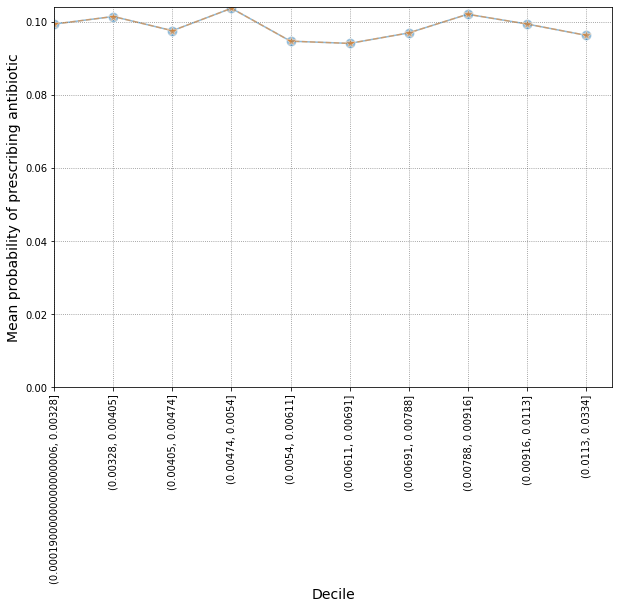


AUROC of LR for deciles with development and validation data: 0.51394 and 0.49221
AUROC of RF for deciles with development and validation data: 0.52744 and 0.50042
LR coefficients:
                                               OR  Lower CI  Upper CI
bins_(0.00019000000000000006, 0.00328]  0.112660  0.100810  0.125903
bins_(0.00328, 0.00405]                 0.114222  0.102207  0.127649
bins_(0.00405, 0.00474]                 0.109609  0.097935  0.122675
bins_(0.00474, 0.0054]                  0.123825  0.111210  0.137871
bins_(0.0054, 0.00611]                  0.104727  0.093312  0.117538
bins_(0.00611, 0.00691]                 0.108582  0.096891  0.121683
bins_(0.00691, 0.00788]                 0.109159  0.097437  0.122292
bins_(0.00788, 0.00916]                 0.115406  0.103253  0.128989
bins_(0.00916, 0.0113]                  0.108074  0.096462  0.121084
bins_(0.0113, 0.0334]                   0.107914  0.096305  0.120922
antibacterial_brit                      0.987132  0.963432

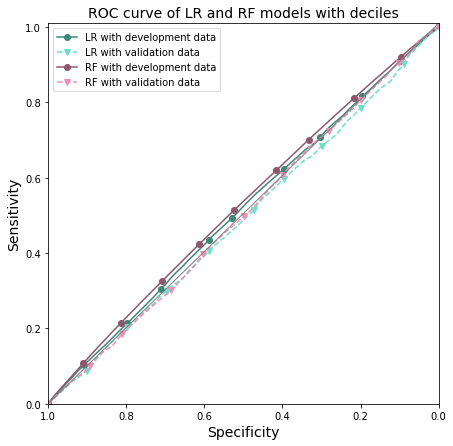

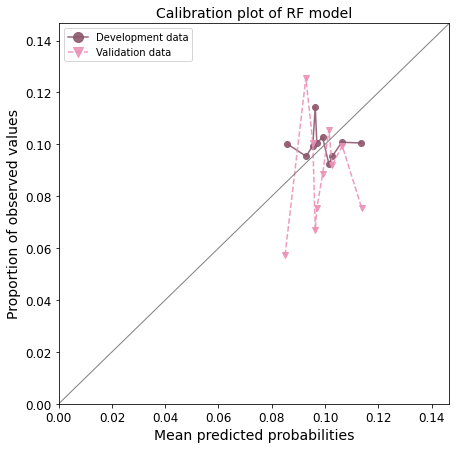

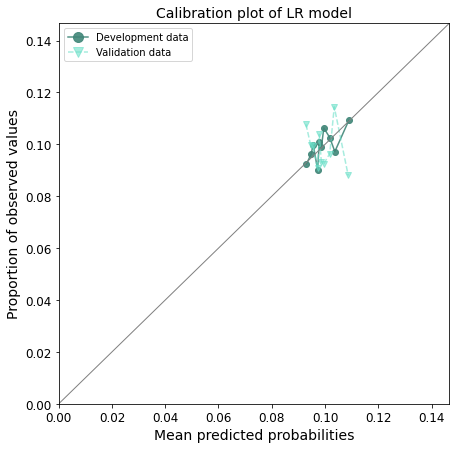

In [40]:
#build cox model for hosp prediction using non ab users' data
prob_pred_throat_no_abs_incdt_during_pandemic, prob_pred_throat_no_abs_incdt_during_pandemic_bin = cox_build('throat', 'incdt_during_pandemic', data_throat_incdt_during_pandemic, data_throat_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('throat', 'incdt_during_pandemic_deciles', prob_pred_throat_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('throat', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

In [41]:
#build cox model for hosp prediction using non ab users' data
prob_pred_throat_no_abs_incdt_post_2nd_lockdown, prob_pred_throat_no_abs_incdt_post_2nd_lockdown_bin = cox_build('throat', 'incdt_post_2nd_lockdown', data_throat_incdt_post_2nd_lockdown, data_throat_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('throat', 'incdt_post_2nd_lockdown_deciles', prob_pred_throat_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('throat', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3129 total observations, 3118 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 3129
number of events observed = 11
   partial log-likelihood = -69.80
         time fit was run = 2023-06-28 14:25:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.75            -1.30             1.64                 0.27                 5.15
CCI_cat[T.medium]              -18.73       0.00    6005.81        -11789.89         11752.43                 0.00                  inf
CCI_cat[T.high]                 -0.38       0.68       1.19            -2.72             1.96                 0.07                 7.09
CCI_cat[T.very_high]            -1.04       0.35       1.19            -3.37             1.30                 0.03                 3.66
age_cat[T.25_34]                 0.50       1.65       0.96            -1.38             2.38                 0.25                10.83
age_cat[T.35_44]                -0.52       0.60       1.26            -2.99             1.95                 0.05                 7.03
age_cat[T.45_54]                 0.50       1.66       1.03            -1.52             2.53                 0.22                12.56
age_cat[T.55_64]                -0.07       0.93       1.04            -2.10             1.96                 0.12                 7.12
age_cat[T.65_74]               -18.13       0.00    6931.69        -13603.99         13567.74                 0.00                  inf
age_cat[T.75_more]              -0.26       0.77       1.25            -2.72             2.20                 0.07                 9.04
antibacterial_brit               0.04       1.04       0.22            -0.39             0.47                 0.68                 1.60
bmi_cat[T.obese]                -1.18       0.31       0.90            -2.96             0.59                 0.05                 1.80
bmi_cat[T.overweight]           -0.50       0.60       1.05            -2.56             1.55                 0.08                 4.71
bmi_cat[T.underweight]           0.60       1.82       1.30            -1.94             3.14                 0.14                23.15
bmi_cat[T.unknown]              -0.92       0.40       1.06            -2.99             1.15                 0.05                 3.15
ethnicity[T.other]             -18.35       0.00    9520.03        -18677.26         18640.56                 0.00                  inf
ethnicity[T.unknown]             0.03       1.03       1.20            -2.32             2.38                 0.10                10.81
ethnicity[T.white]               0.08       1.08       1.10            -2.08             2.24                 0.12                 9.43
flu_vaccine[T.yes]             -18.18       0.00    7413.30        -14547.98         14511.61                 0.00                  inf
imd[T.medium]                   -0.57       0.56       1.25            -3.03             1.89                 0.05                 6.61
imd[T.unaffluent]                0.52       1.68       0.94            -1.33             2.36                 0.26                10.64
imd[T.unknown]                 -18.15       0.00   11179.50        -21929.57         21893.28                 0.00                  inf
imd[T.very_affluent]             0.22       1.25       1.02            -1.78             2.23                 0.17                 9.29
imd[T.very_unaffluent]           0.25       1.29       0.94            -1.59             2.10                 0.20                 8.15
region[T.east_midlands]        -18.97       0.00    8921.87        -1750

13180


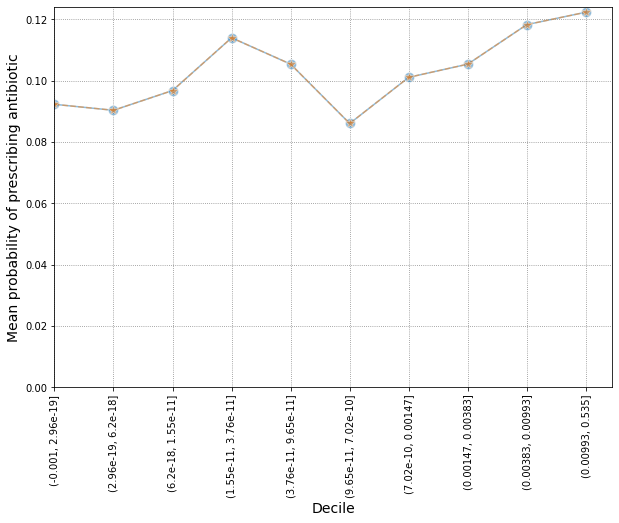


AUROC of LR for deciles with development and validation data: 0.55116 and 0.48562
AUROC of RF for deciles with development and validation data: 0.61618 and 0.48388
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.001, 2.96e-19]    0.093549  0.064246  0.136216
bins_(0.00147, 0.00383]    0.115310  0.081425  0.163296
bins_(0.00383, 0.00993]    0.127938  0.090831  0.180205
bins_(0.00993, 0.535]      0.145669  0.105031  0.202029
bins_(1.55e-11, 3.76e-11]  0.117824  0.084037  0.165196
bins_(2.96e-19, 6.2e-18]   0.085052  0.057339  0.126159
bins_(3.76e-11, 9.65e-11]  0.126611  0.090312  0.177498
bins_(6.2e-18, 1.55e-11]   0.112047  0.078646  0.159634
bins_(7.02e-10, 0.00147]   0.097061  0.066972  0.140667
bins_(9.65e-11, 7.02e-10]  0.092187  0.062772  0.135387
antibacterial_brit         1.055488  0.979754  1.137077

RF feature importance:
                             rf_coef
antibacterial_brit         0.612463
bins_(0.00993, 0.535]      0.057558
bins_(2.96e-

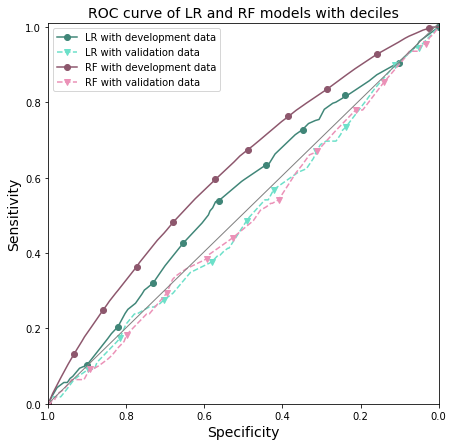

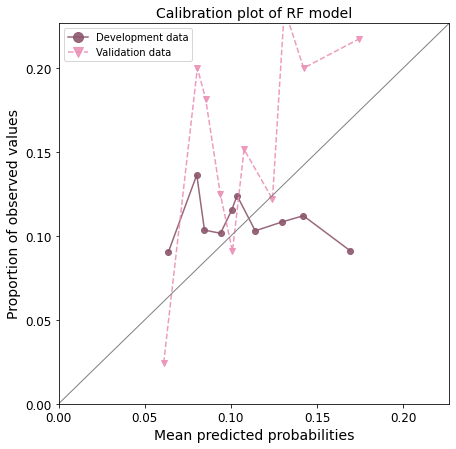

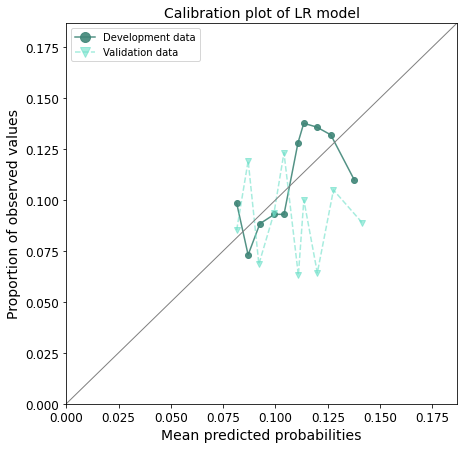

In [ ]:
#build cox model for hosp prediction using non ab users' data
prob_pred_throat_no_abs_prevl_prepandemic, prob_pred_throat_no_abs_prevl_prepandemic_bin = cox_build('throat', 'prevl_prepandemic', data_throat_prevl_prepandemic, data_throat_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('throat', 'prevl_prepandemic_deciles', prob_pred_throat_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('throat', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 3594 total observations, 3566 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 3594
number of events observed = 28
   partial log-likelihood = -214.07
         time fit was run = 2023-06-28 14:25:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.12       0.33       0.59            -2.28             0.03                 0.10                 1.04
CCI_cat[T.medium]               -0.17       0.85       0.54            -1.23             0.89                 0.29                 2.44
CCI_cat[T.high]                 -0.84       0.43       0.81            -2.42             0.75                 0.09                 2.11
CCI_cat[T.very_high]            -0.07       0.93       0.54            -1.14             0.99                 0.32                 2.69
age_cat[T.25_34]                -0.49       0.61       0.74            -1.93             0.95                 0.14                 2.60
age_cat[T.35_44]                -0.54       0.58       0.74            -1.98             0.90                 0.14                 2.47
age_cat[T.45_54]                 0.19       1.21       0.61            -1.01             1.40                 0.36                 4.04
age_cat[T.55_64]                 0.29       1.34       0.61            -0.90             1.49                 0.40                 4.44
age_cat[T.65_74]                -0.20       0.82       0.68            -1.53             1.13                 0.22                 3.08
age_cat[T.75_more]              -1.62       0.20       1.10            -3.78             0.53                 0.02                 1.70
antibacterial_brit              -0.32       0.73       0.17            -0.65             0.01                 0.52                 1.01
bmi_cat[T.obese]                -0.45       0.64       0.65            -1.72             0.82                 0.18                 2.27
bmi_cat[T.overweight]           -0.73       0.48       0.92            -2.54             1.08                 0.08                 2.94
bmi_cat[T.underweight]          -0.30       0.74       1.16            -2.58             1.98                 0.08                 7.26
bmi_cat[T.unknown]              -0.20       0.82       0.69            -1.55             1.14                 0.21                 3.13
ethnicity[T.other]              -0.05       0.95       1.01            -2.02             1.93                 0.13                 6.86
ethnicity[T.unknown]            -0.08       0.93       0.82            -1.69             1.53                 0.19                 4.64
ethnicity[T.white]               0.17       1.19       0.75            -1.30             1.65                 0.27                 5.19
flu_vaccine[T.yes]              -0.31       0.73       0.74            -1.77             1.14                 0.17                 3.12
imd[T.medium]                   -0.65       0.52       0.63            -1.89             0.59                 0.15                 1.80
imd[T.unaffluent]               -0.89       0.41       0.70            -2.25             0.47                 0.11                 1.60
imd[T.unknown]                   0.12       1.13       0.81            -1.48             1.71                 0.23                 5.54
imd[T.very_affluent]            -0.13       0.88       0.56            -1.23             0.98                 0.29                 2.65
imd[T.very_unaffluent]          -0.22       0.80       0.56            -1.33             0.88                 0.27                 2.41
region[T.east_midlands]          1.30       3.66       1.12            

13095


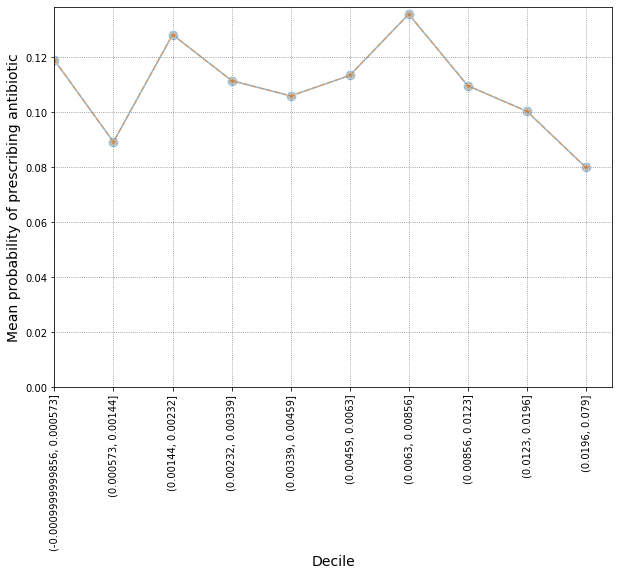


AUROC of LR for deciles with development and validation data: 0.55650 and 0.49323
AUROC of RF for deciles with development and validation data: 0.60206 and 0.48104
LR coefficients:
                                          OR  Lower CI  Upper CI
bins_(-0.0009999999856, 0.000573]  0.138148  0.099847  0.191142
bins_(0.000573, 0.00144]           0.077383  0.050997  0.117420
bins_(0.00144, 0.00232]            0.163604  0.120621  0.221904
bins_(0.00232, 0.00339]            0.115586  0.082059  0.162811
bins_(0.00339, 0.00459]            0.121382  0.087424  0.168530
bins_(0.00459, 0.0063]             0.146759  0.107752  0.199887
bins_(0.0063, 0.00856]             0.139967  0.102784  0.190603
bins_(0.00856, 0.0123]             0.129320  0.094989  0.176059
bins_(0.0123, 0.0196]              0.103927  0.073852  0.146249
bins_(0.0196, 0.079]               0.094214  0.066576  0.133326
antibacterial_brit                 0.986649  0.914393  1.064615

RF feature importance:
                         

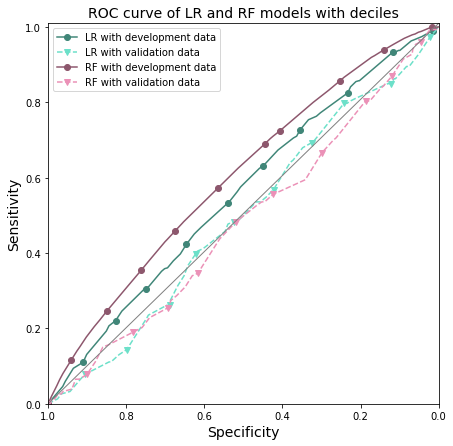

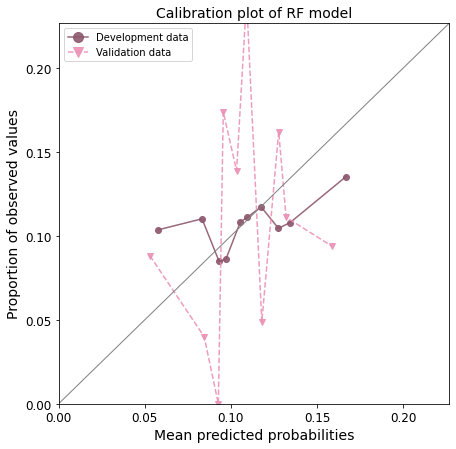

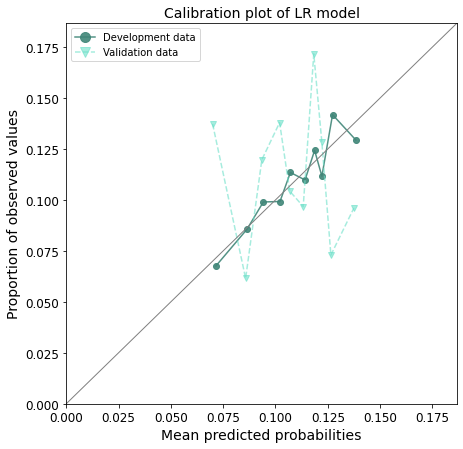

In [ ]:
#build cox model for hosp prediction using non ab users' data
prob_pred_throat_no_abs_prevl_during_pandemic, prob_pred_throat_no_abs_prevl_during_pandemic_bin = cox_build('throat', 'prevl_during_pandemic', data_throat_prevl_during_pandemic, data_throat_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('throat', 'prevl_during_pandemic_deciles', prob_pred_throat_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('throat', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 5222 total observations, 5181 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 5222
number of events observed = 41
   partial log-likelihood = -338.95
         time fit was run = 2023-06-28 14:25:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.58       1.79       0.57            -0.53             1.69                 0.59                 5.44
CCI_cat[T.medium]                0.77       2.16       0.59            -0.39             1.93                 0.67                 6.90
CCI_cat[T.high]                  0.74       2.10       0.67            -0.58             2.06                 0.56                 7.85
CCI_cat[T.very_high]             0.72       2.05       0.61            -0.49             1.92                 0.62                 6.83
age_cat[T.25_34]                -0.60       0.55       0.63            -1.83             0.63                 0.16                 1.88
age_cat[T.35_44]                -0.43       0.65       0.59            -1.58             0.72                 0.21                 2.06
age_cat[T.45_54]                -0.62       0.54       0.63            -1.86             0.61                 0.16                 1.84
age_cat[T.55_64]                 0.09       1.10       0.52            -0.93             1.11                 0.39                 3.05
age_cat[T.65_74]                -0.07       0.94       0.54            -1.12             0.99                 0.33                 2.68
age_cat[T.75_more]              -0.21       0.81       0.56            -1.31             0.88                 0.27                 2.41
antibacterial_brit              -0.01       0.99       0.11            -0.22             0.21                 0.80                 1.24
bmi_cat[T.obese]                -0.13       0.88       0.55            -1.20             0.94                 0.30                 2.56
bmi_cat[T.overweight]           -0.25       0.78       0.71            -1.64             1.14                 0.19                 3.14
bmi_cat[T.underweight]          -0.42       0.66       1.12            -2.61             1.78                 0.07                 5.95
bmi_cat[T.unknown]              -0.21       0.81       0.59            -1.37             0.96                 0.25                 2.61
ethnicity[T.other]              -0.19       0.83       0.92            -1.99             1.61                 0.14                 5.00
ethnicity[T.unknown]             0.36       1.44       0.64            -0.90             1.62                 0.41                 5.07
ethnicity[T.white]               0.00       1.00       0.62            -1.21             1.21                 0.30                 3.35
flu_vaccine[T.yes]              -0.82       0.44       0.73            -2.24             0.61                 0.11                 1.84
imd[T.medium]                   -0.20       0.82       0.67            -1.52             1.12                 0.22                 3.05
imd[T.unaffluent]                0.64       1.90       0.55            -0.44             1.72                 0.65                 5.57
imd[T.unknown]                 -16.43       0.00    3297.25         -6478.91          6446.06                 0.00                  inf
imd[T.very_affluent]             0.77       2.17       0.54            -0.29             1.83                 0.75                 6.26
imd[T.very_unaffluent]           0.84       2.32       0.54            -0.22             1.90                 0.80                 6.71
region[T.east_midlands]         -0.30       0.74       0.77            

13055


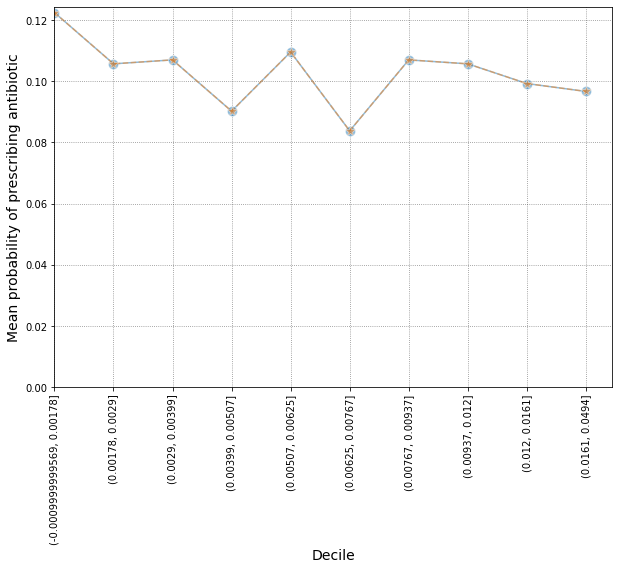


AUROC of LR for deciles with development and validation data: 0.54278 and 0.50521
AUROC of RF for deciles with development and validation data: 0.59309 and 0.48889
LR coefficients:
                                         OR  Lower CI  Upper CI
bins_(-0.0009999999569, 0.00178]  0.136441  0.105386  0.176649
bins_(0.00178, 0.0029]            0.110128  0.083272  0.145645
bins_(0.0029, 0.00399]            0.114150  0.086442  0.150740
bins_(0.00399, 0.00507]           0.089129  0.065983  0.120395
bins_(0.00507, 0.00625]           0.114489  0.087045  0.150587
bins_(0.00625, 0.00767]           0.081985  0.059983  0.112057
bins_(0.00767, 0.00937]           0.122454  0.093502  0.160370
bins_(0.00937, 0.012]             0.122054  0.093612  0.159138
bins_(0.012, 0.0161]              0.110012  0.083545  0.144864
bins_(0.0161, 0.0494]             0.096767  0.072668  0.128857
antibacterial_brit                1.039323  0.980068  1.102160

RF feature importance:
                                    r

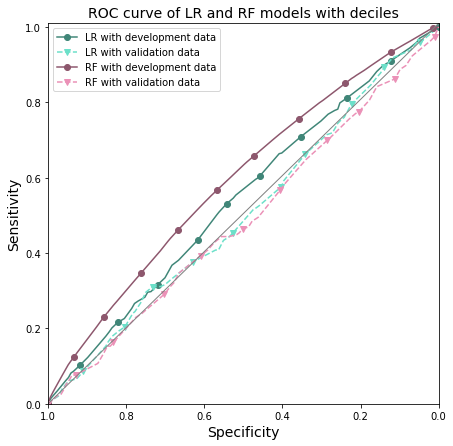

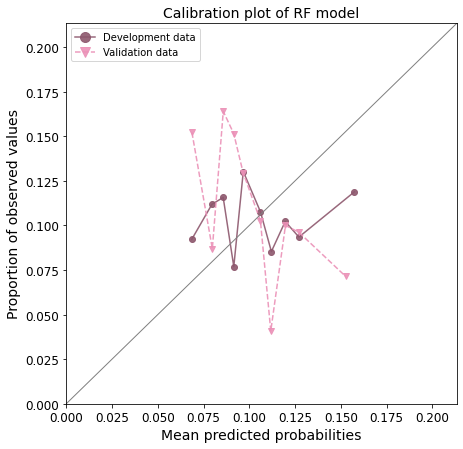

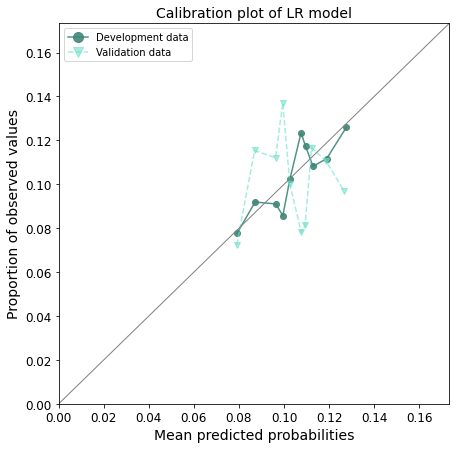

In [ ]:
#build cox model for hosp prediction using non ab users' data
prob_pred_throat_no_abs_prevl_post_2nd_lockdown, prob_pred_throat_no_abs_prevl_post_2nd_lockdown_bin = cox_build('throat', 'prevl_post_2nd_lockdown', data_throat_prevl_post_2nd_lockdown, data_throat_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('throat', 'prevl_post_2nd_lockdown_deciles', prob_pred_throat_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('throat', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)